In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, Normalizer
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import cohen_kappa_score, confusion_matrix,ConfusionMatrixDisplay

from xgboost import XGBRegressor

# !pip install pgeocode

# import pgeocode

In [2]:
train = pd.read_csv('/kaggle/input/playground-series-s3e6/train.csv', dtype={'cityCode': object})
test = pd.read_csv('/kaggle/input/playground-series-s3e6/test.csv', dtype={'cityCode': object})
original = pd.read_csv('/kaggle/input/paris-housing-price-prediction/ParisHousing.csv', dtype={'cityCode': object})

In [3]:
original = original.reset_index()
original['id'] = original['index'] + 1000000
original = original.drop(columns = ['index'])
train.head()

,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price
0,0,34291,24,1,0,47,35693,2,1,2000,0,1,8,5196,369,0,3,3436795.2
1,1,95145,60,0,1,60,34773,1,4,2000,0,1,729,4496,277,0,6,9519958.0
2,2,92661,45,1,1,62,45457,4,8,2020,1,1,7473,8953,245,1,9,9276448.1
3,3,97184,99,0,0,59,15113,1,1,2000,0,1,6424,8522,256,1,9,9725732.2
4,4,61752,100,0,0,57,64245,8,4,2018,1,0,7151,2786,863,0,7,6181908.8


In [4]:
original.head()

,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,price,id
0,75523,3,0,1,63,9373,3,8,2005,0,1,4313,9005,956,0,7,7559081.5,1000000
1,80771,39,1,1,98,39381,8,6,2015,1,0,3653,2436,128,1,2,8085989.5,1000001
2,55712,58,0,1,19,34457,6,8,2021,0,0,2937,8852,135,1,9,5574642.1,1000002
3,32316,47,0,0,6,27939,10,4,2012,0,1,659,7141,359,0,3,3232561.2,1000003
4,70429,19,1,1,90,38045,3,7,1990,1,0,8435,2429,292,1,4,7055052.0,1000004


In [5]:
train['cityCode'] = train['cityCode'].str.zfill(5)
test['cityCode'] = train['cityCode'].str.zfill(5)
original['cityCode'] = train['cityCode'].str.zfill(5)

In [6]:
print(len(train))
print(len(test))
print(len(original))

22730
15154
10000


In [7]:
num_cols = train.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('id')
num_cols.remove('price')

<AxesSubplot:ylabel='price'>

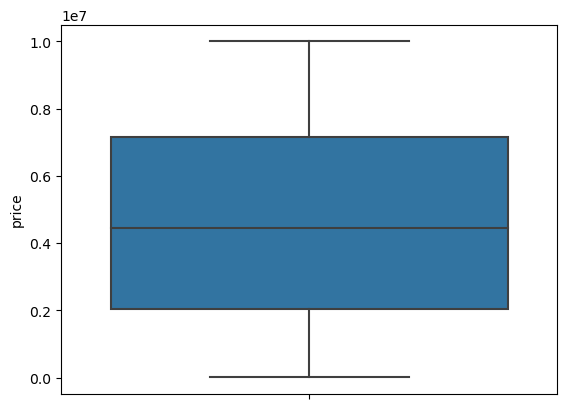

In [8]:
sns.boxplot(y = 'price',data = train)

In [9]:
# eiffel_zip = '75007'
# dist = pgeocode.GeoDistance('fr')
# train['Dist_From_Eiffel'] = train['cityCode'].apply(lambda x: dist.query_postal_code(eiffel_zip , x))

# nomi = pgeocode.Nominatim('fr')
# cols = ['place_name','state_name','state_code','latitude','longitude']

# train[cols] = train.apply(lambda row: nomi.query_postal_code(row['cityCode'])[cols], axis=1, result_type='expand')
# train.head()

# original[cols] = original.apply(lambda row: nomi.query_postal_code(row['cityCode'])[cols], axis=1, result_type='expand')
# original.head()

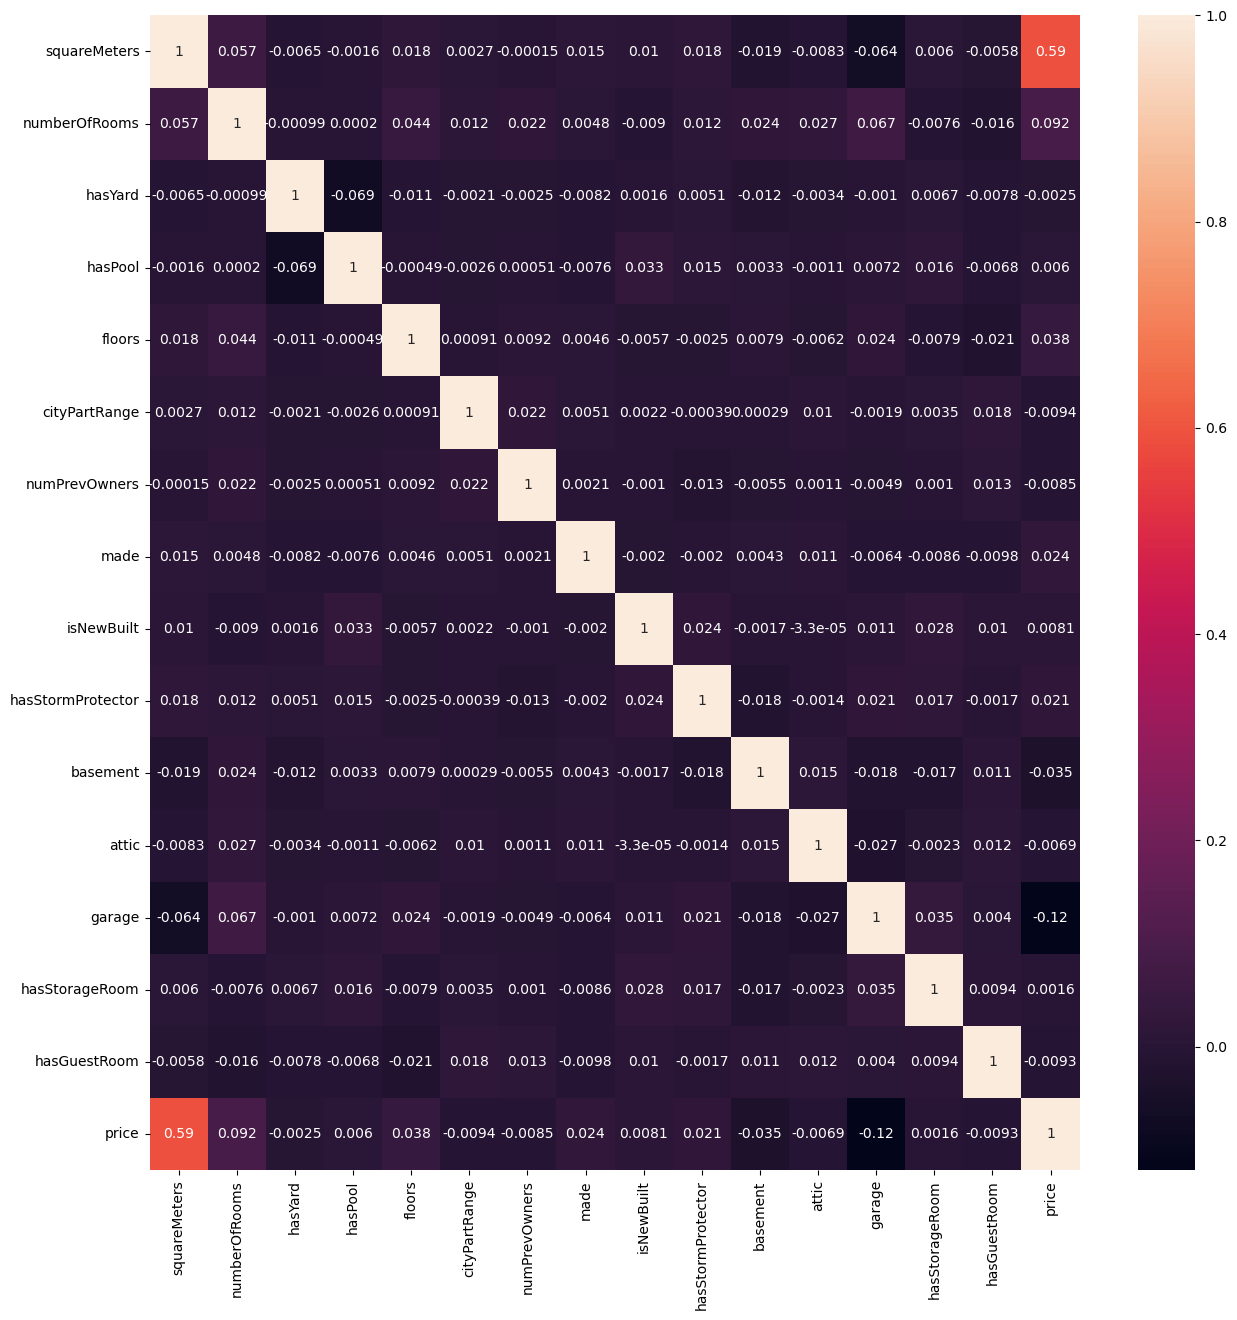

In [10]:
corr_cols = num_cols + ['price']
plt.figure(figsize=(15,15))
sns.heatmap(train[corr_cols].corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

In [11]:
made = pd.DataFrame(train.groupby(['made']).size()).reset_index().rename(columns = {0:'Count'})
made = made[made['made']< 5000]

made1 = pd.DataFrame(train.groupby(['made'])['price'].mean()).reset_index().rename(columns = {0:'mean_price'})

made = pd.merge(made,made1, on = 'made', how = 'inner')

In [12]:
made[made['made']<= 2000].corr()

,made,Count,price
made,1.000000,0.672256,-0.790501
Count,0.672256,1.000000,-0.486776
price,-0.790501,-0.486776,1.000000


In [13]:
made[made['made']> 2007].corr()

,made,Count,price
made,1.000000,0.025725,-0.069582
Count,0.025725,1.000000,-0.346971
price,-0.069582,-0.346971,1.000000


In [14]:
train = pd.concat([train,original])

In [15]:
train_1 = train[train['made']<=2000]
test_1 = test[test['made']<=2000]
train_2 = train[(train['made']>=2001) & (train['made']<=2007)]
test_2 = test[(test['made']>=2001) & (test['made']<=2007)]
train_3 = train[train['made']>2007]
test_3 = test[test['made']>2007]

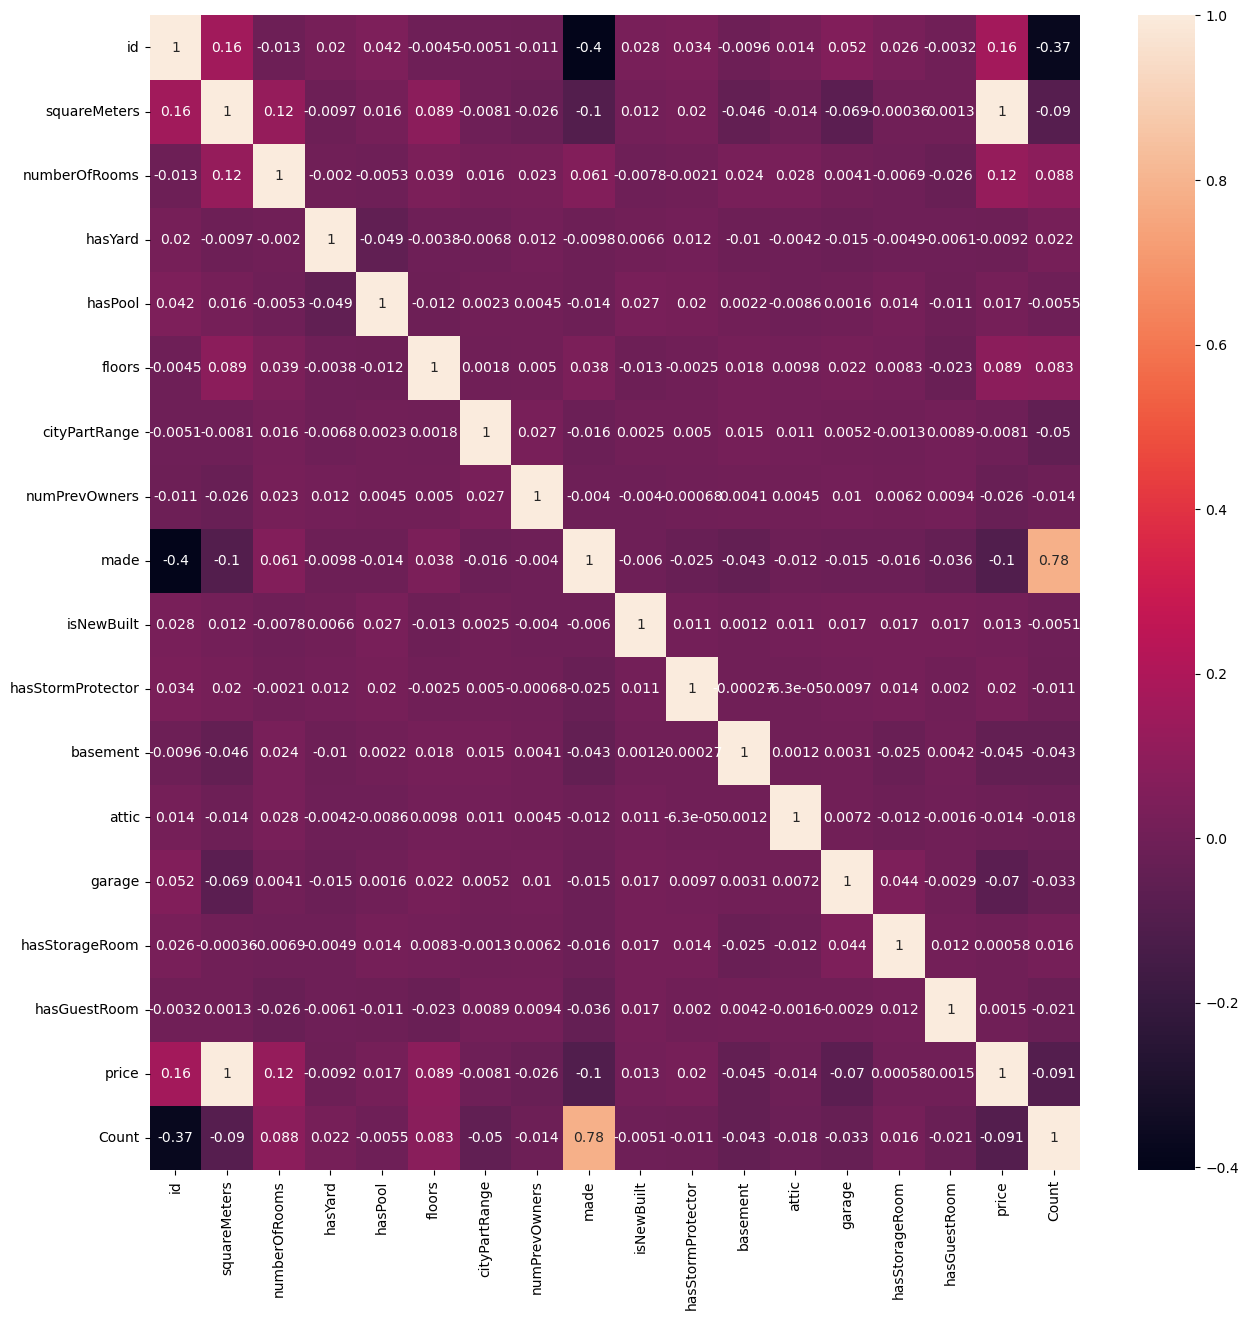

In [16]:
train_1 = pd.merge(train_1,made[['made','Count']], on = 'made', how = 'inner')
test_1 = pd.merge(test_1,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_1.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

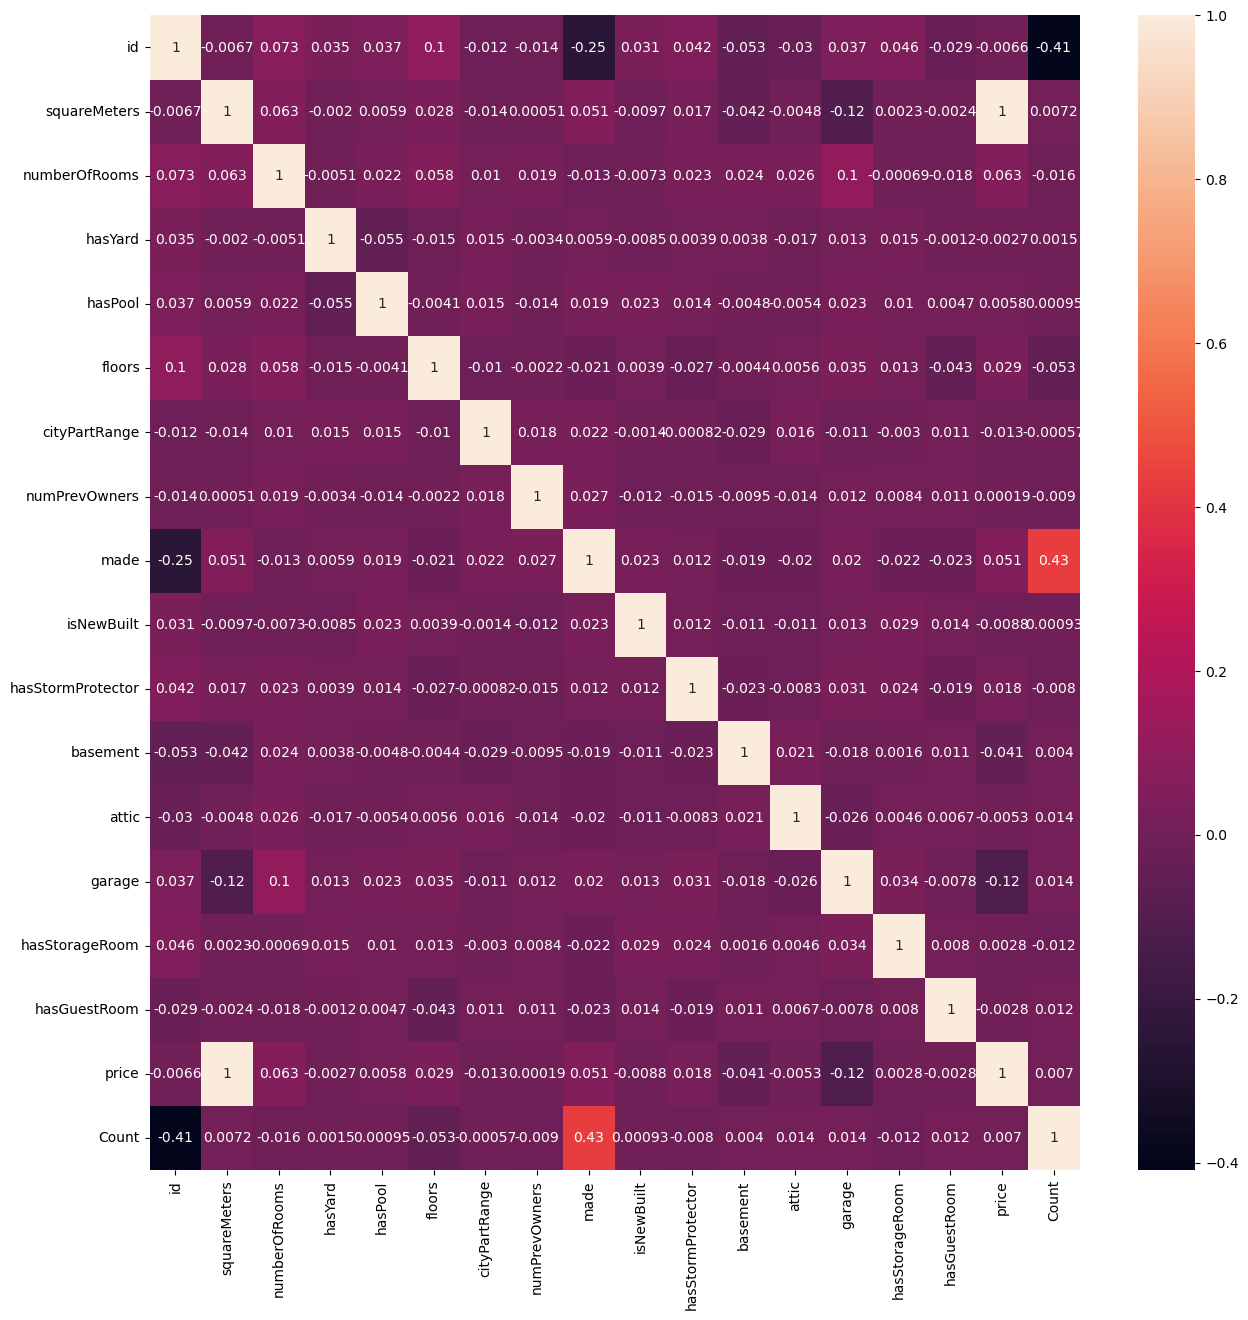

In [17]:
train_2 = pd.merge(train_2,made[['made','Count']], on = 'made', how = 'inner')
test_2 = pd.merge(test_2,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_2.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

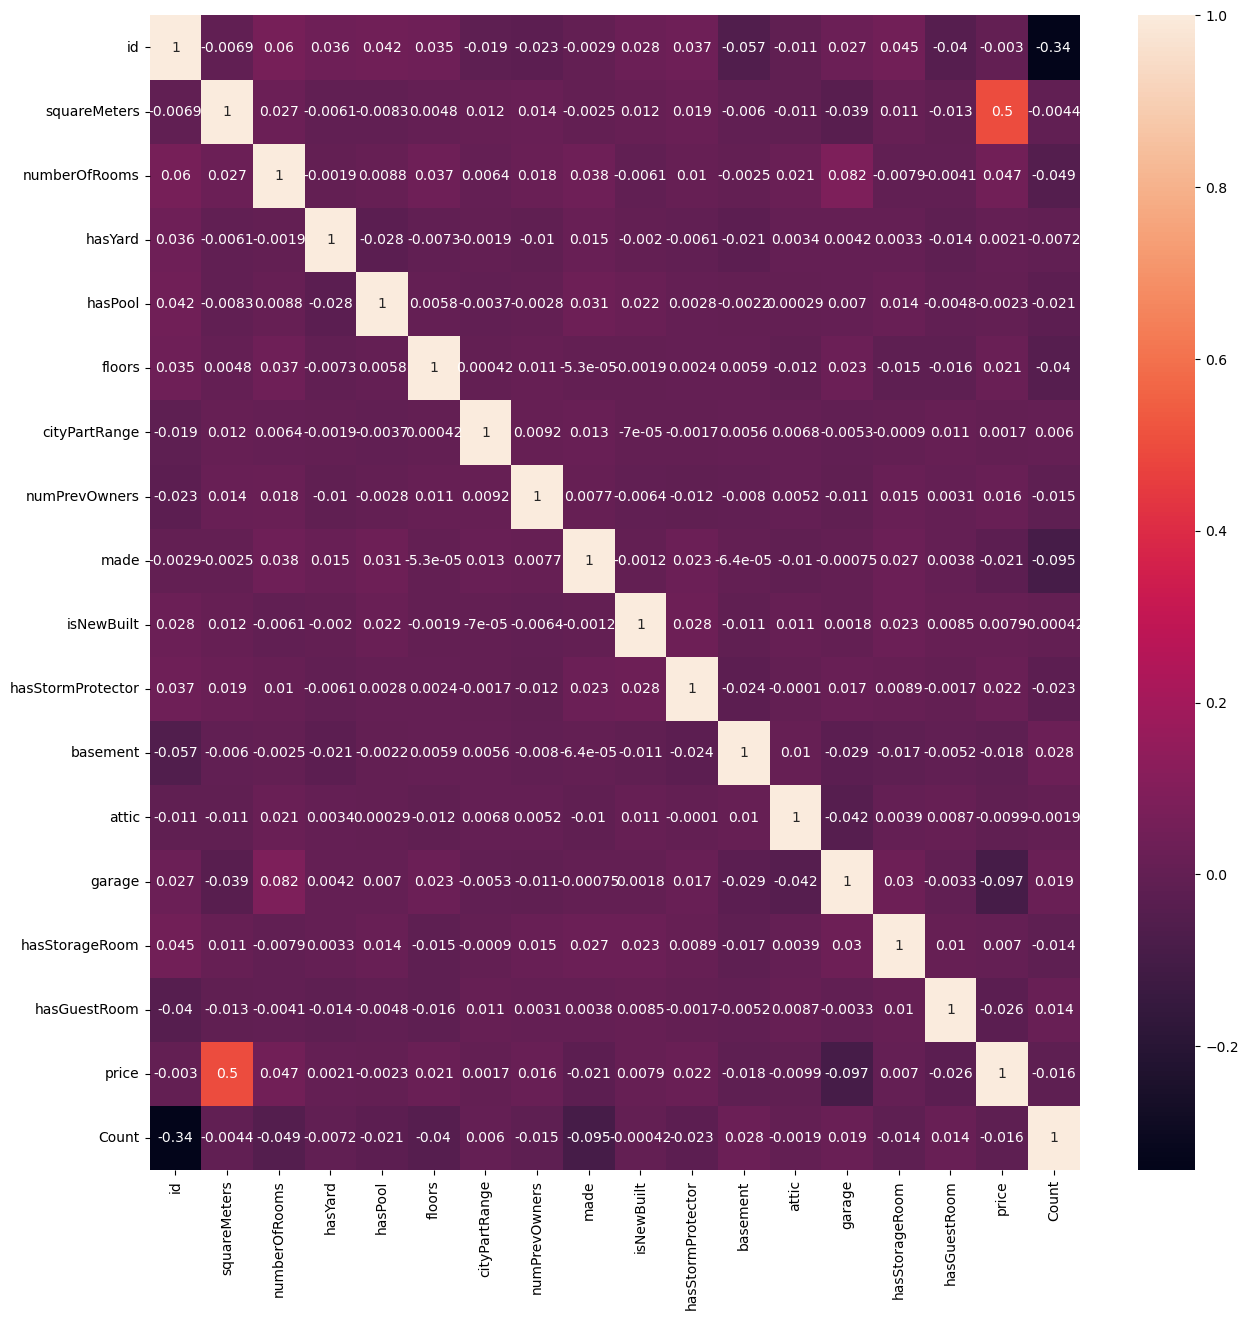

In [18]:
train_3 = pd.merge(train_3,made[['made','Count']], on = 'made', how = 'inner')
test_3 = pd.merge(test_3,made[['made','Count']], on = 'made', how = 'inner')
plt.figure(figsize=(15,15))
sns.heatmap(train_3.corr(),annot=True)
# plt.savefig("Heatmap.png")
plt.show()

In [19]:
num_cols = num_cols + ['Count']

In [20]:
X1 = train_1[num_cols]
# X1 = train_1[['squareMeters']]
y1 = train_1['price']

model = XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB = model.fit(X1,y1)


X_test = test_1[num_cols]
# X_test = test_1[['squareMeters']]
prediction = XGB.predict(X_test)

test_1['price'] = prediction
test_1

[12:50:41] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22730,47580,89,0,1,8,35693,5,3,1995,0,0,6885,8181,241,0,8,631,4758011.000
1,22751,69856,47,0,1,26,77004,1,8,1995,1,0,17,853,854,1,8,631,6995771.000
2,22755,23608,51,0,0,31,84602,10,6,1995,1,0,6410,8153,945,1,8,631,2364168.250
3,22775,67724,11,1,1,64,51336,2,10,1995,0,1,7448,1932,128,1,2,631,6778856.500
4,22815,50778,39,0,1,94,49199,2,1,1995,0,0,5294,7178,614,0,2,631,5074851.500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5584,35303,84696,45,0,0,14,24522,7,4,1991,0,1,8681,5246,524,1,6,30,8468765.000
5585,35522,42630,34,0,1,25,37363,9,7,1991,1,0,7976,331,236,0,0,30,4239987.000
5586,35686,18316,20,0,1,5,28086,2,6,1991,0,0,6574,2166,127,1,5,30,1847247.375
5587,36267,41700,48,0,1,8,84704,5,7,1991,0,0,743,7716,194,1,2,30,4206274.500


In [21]:
X2 = train_2[num_cols]
# X2 = train_2[['squareMeters']]
y2 = train_2['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X2,y2)

X_test = test_2[num_cols]
# X_test = test_2[['squareMeters']]
prediction=XGB.predict(X_test)

test_2['price'] = prediction
test_2

[12:50:54] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22740,69567,38,0,0,11,54900,8,3,2003,0,1,8194,8627,124,0,3,1156,6966366.00
1,22776,15351,34,0,0,10,68109,3,6,2003,0,0,6341,5844,929,1,6,1156,1544070.75
2,22868,4198,6,1,0,80,38929,3,8,2003,0,0,3795,4194,885,1,8,1156,405859.50
3,22887,62064,86,1,1,35,48037,2,3,2003,1,0,8000,2600,976,0,10,1156,6180837.50
4,22907,91618,4,0,0,36,74838,8,3,2003,1,1,6484,2731,121,1,5,1156,9159348.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3225,36015,73748,84,0,0,32,85082,5,2,2001,1,1,4309,7379,273,1,9,59,7383201.50
3226,36030,90170,63,1,1,20,04081,9,5,2001,1,0,4196,2528,945,1,3,59,9012547.00
3227,36156,41700,8,0,0,64,53916,7,9,2001,1,0,8163,8153,194,0,8,59,4174734.75
3228,36298,55620,61,1,1,90,66390,3,4,2001,1,1,9867,7179,548,0,1,59,5568641.50


In [22]:
X3 = train_3[num_cols]
y3 = train_3['price']

model=XGBRegressor(max_depth=3, learning_rate=0.24 , n_estimators=2000, objective='reg:linear', booster='gbtree')
XGB=model.fit(X3,y3)

X_test = test_3[num_cols]
prediction=XGB.predict(X_test)

test_3['price'] = prediction
test_3

[12:51:04] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.


,id,squareMeters,numberOfRooms,hasYard,hasPool,floors,cityCode,cityPartRange,numPrevOwners,made,isNewBuilt,hasStormProtector,basement,attic,garage,hasStorageRoom,hasGuestRoom,Count,price
0,22733,16354,47,1,1,9,15113,6,5,2019,1,1,705,5097,122,1,5,956,1644086.750
1,22748,35423,52,1,1,24,72385,6,8,2019,1,0,8486,4375,489,1,5,956,3558887.000
2,22820,85256,74,0,1,39,50147,1,1,2019,0,1,3945,5240,745,1,0,956,8520852.000
3,22826,68847,74,1,1,80,22176,10,6,2019,0,1,9789,9476,847,1,5,956,6885240.000
4,22840,15815,13,1,1,7,22460,7,3,2019,1,1,2494,8575,827,1,5,956,1570423.875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6330,36857,54484,38,1,1,78,52734,8,6,2011,0,1,8235,8136,114,1,8,68,5453139.500
6331,37118,54484,25,1,0,94,46686,4,5,2011,0,1,8163,8889,241,0,6,68,5447892.000
6332,37278,27949,84,1,0,94,98846,5,9,2011,1,1,8578,9248,245,1,1,68,2789866.750
6333,37431,76932,85,0,1,89,16768,5,4,2011,0,0,8767,8149,583,1,0,68,7705767.000


In [23]:
submission = pd.concat([test_1,test_2,test_3])
submission = submission[['id','price']]
submission = submission.sort_values(by = ['id'])
submission.to_csv('submission.csv',index = False)
submission.head()

,id,price
0,22730,4758011.00
402,22731,6219134.00
827,22732,9070699.00
0,22733,1644086.75
685,22734,6751079.00
